**IMPORTANT** - running on the full Preston observatory uses about 12GB of memory as of 10/14/2019

In [2]:
import numpy as np
import pandas as pd
from enum import Enum

from nquads import NQuads
from prestongraph import *

### Get provenance log

On a large preston.acis.ufl.edu observatory it can take a while to run ```preston ls```, so we store its output at a temporary location
```shell
preston ls --remote http://preston.acis.ufl.edu > tmp/nquads
```

### Index the provenance logs

In [3]:
class Observatory:
    def __init__(self, name, dataPath=None, outputPath=None):
        self.name = name
        self.dataPath = dataPath
        self.index = None
        
        if outputPath is not None:
            self.outputPath = outputPath
        else:
            self.outputPath = "./" + name.lower().replace(" ", "-") + "-analysis/"

In [69]:
def MakeIndexFromLogs(paths):
    #import sys
    #import io
    global line
    global nQuad
    index = Index()

    if type(paths) == str:
        paths = [paths]
    #sys.stdin = io.FileIO(path)

    # Parse the provenance log into a list of n-quads
    for path in paths:
        with open(path) as file:
            parsingGenerations = False
            for line in file:
                nQuads = NQuads.Parse(str(line))
                for nQuad in nQuads:
                    if len(nQuad) < 3: # Only ingest well-formed n-quads
                        continue
                    elif not parsingGenerations:
                        if nQuad[1][0] == "http://www.w3.org/ns/prov#qualifiedGeneration":
                            parsingGenerations = True
                        elif nQuad[1][0] not in (
                            "http://www.w3.org/ns/prov#Activity",
                            "http://purl.org/dc/terms/description",
                            "http://www.w3.org/ns/prov#startedAtTime"
                        ):
                            continue
                    index.Ingest(nQuad)

    return index

In [ ]:
observatories = []

In [60]:
observatories.append(Observatory("iDigBio", "../zenodo_deeplinker/idigbio.nq"))

In [ ]:
observatories.append(Observatory("GBIF", "../zenodo_deeplinker/gbif.nq"))

In [115]:
observatories.append(Observatory("DataONE", "../zenodo_dataone/nquads"))

In [117]:
observatories.append(Observatory("BHL", "../zenodo_bhl/nquads"))

In [ ]:
# observatories.append(Observatory("Deeplinker", "../zenodo_deeplinker/nquads"))

In [ ]:
# observatories.append(Observatory("All", [x.dataPath for x in observatories]))

In [68]:
line

' <http://www.w3.org/ns/prov#qualifiedGeneration>  .\n'

In [67]:
nQuad

[('http://www.w3.org/ns/prov#qualifiedGeneration',)]

In [118]:
%%time

import os

for observatory in observatories:
    if observatory.index is not None:
        print("Skipping %s; already loaded" % observatory.name)
        continue

    # Prepare a place to store results
    try:
        os.mkdir(observatory.outputPath)
    except OSError:
        pass
    
    # Make an index
    if observatory.dataPath is None:
        print("Skipping %s; data path not specified" % observatory.name)
    else:
        print("Reading %s..." % observatory.name)
        %time observatory.index = MakeIndexFromLogs(observatory.dataPath)
        print("Done reading %s\n" % observatory.name)

Skipping iDigBio; already loaded
Skipping GBIF; already loaded
Reading DataONE...
CPU times: user 8min 30s, sys: 1min 36s, total: 10min 6s
Wall time: 10min 6s
Done reading DataONE

Reading BHL...
CPU times: user 4min 20s, sys: 1min 13s, total: 5min 33s
Wall time: 5min 33s
Done reading BHL

CPU times: user 12min 50s, sys: 2min 49s, total: 15min 39s
Wall time: 15min 39s


In [160]:
observatory = observatories[-2]
observatoryName = observatory.name
fullIndex = observatory.index
outputPath = observatory.outputPath
dataPath = observatory.dataPath
print("Using %s" % observatoryName)

Using DataONE


In [161]:
for x in fullIndex.verbLookup["http://www.w3.org/ns/prov#startedAtTime"].triples: print(x)

b8fdca11-c665-45f7-9fc6-d14457b534f2	http://www.w3.org/ns/prov#startedAtTime	2019-10-01T01:29:29.672Z
3b294f86-9437-4bda-a4a4-15d3cdda2f58	http://www.w3.org/ns/prov#startedAtTime	2019-06-01T07:32:31.022Z
97892995-268b-4ab7-8d05-e015511075eb	http://www.w3.org/ns/prov#startedAtTime	2019-09-01T15:07:03.524Z
de08ea83-d32a-478b-bf34-7e77ee5a9c81	http://www.w3.org/ns/prov#startedAtTime	2019-08-01T04:21:24.356Z
b34ce2a0-ec51-4fd5-a67a-990d6c08bca5	http://www.w3.org/ns/prov#startedAtTime	2018-12-04T01:25:48.721Z
a0c36b74-4c95-4a7d-9cf1-994b3bc16961	http://www.w3.org/ns/prov#startedAtTime	2019-02-13T08:55:08.176Z
7fe26593-d48d-4c4c-93f2-79885231e36f	http://www.w3.org/ns/prov#startedAtTime	2019-02-08T00:17:15.510Z
d75927b3-8a33-45ed-8e02-bcc35b52b67c	http://www.w3.org/ns/prov#startedAtTime	2019-05-14T20:26:29.383Z
7415c514-572d-4b26-8a95-1133cc77a194	http://www.w3.org/ns/prov#startedAtTime	2019-04-29T19:11:30.720Z
044dea8b-0169-4751-9f61-82f53aa2dbbf	http://www.w3.org/ns/prov#startedAtTime	2018-

In [162]:
print("{:,}".format(len(fullIndex.nodes)), "nodes")

4,586,698 nodes


In [163]:
# formats = set()

# for x in fullIndex.verbLookup["http://purl.org/dc/elements/1.1/format"].triples:
#     formats.add(x.object)

# for x in formats: print(x)

In [164]:
for x in fullIndex.verbs: print(x)

http://www.w3.org/ns/prov#generatedAtTime
http://www.w3.org/ns/prov#wasStartedBy
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://purl.org/pav/createdBy
http://www.w3.org/ns/prov#activity
http://purl.org/dc/terms/bibliographicCitation
http://www.w3.org/ns/prov#qualifiedGeneration
http://purl.org/pav/hasVersion
http://www.w3.org/ns/prov#used
http://www.w3.org/ns/prov#hadMember
http://purl.org/dc/elements/1.1/format
http://www.w3.org/ns/prov#wasAssociatedWith
http://www.w3.org/ns/prov#usedBy
http://www.w3.org/ns/prov#wasGeneratedBy
http://purl.org/dc/terms/description
http://www.w3.org/ns/prov#startedAtTime


In [165]:
def PrintNodeSubTree(node, maxDepth=1, root=True):
    if root:
        for x in node.inwardTriples:
            print(x)

    if maxDepth > 0:
        for x in node.outwardTriples:
            print(x)
            PrintNodeSubTree(x.object, maxDepth - 1, False)

def Peek(nativeSet):
    if len(nativeSet) == 0:
        return None
    else:
        item = nativeSet.pop()
        nativeSet.add(item)
        return item

def ContentIsValid(content):
    return str(content).startswith("http")

### Get crawl UUIDs and sort them by date

In [166]:
class CrawlMeta:
    def __init__(self, position, date):
        # Properties
        self.position = position
        self.date = date

In [167]:
checkDescription = ("http://purl.org/dc/terms/description" in fullIndex.verbLookup)

crawlDates = []
for triple in fullIndex.verbLookup["http://www.w3.org/ns/prov#startedAtTime"].triples:
    crawlUuid = triple.subject
    crawlDate = triple.object

    if checkDescription:
        descriptionTriple = Peek(crawlUuid.outwardTriples & fullIndex.verbLookup["http://purl.org/dc/terms/description"].triples)
        if descriptionTriple.object == "A crawl event that discovers biodiversity archives.":
            crawlDates.append((crawlUuid, crawlDate))
        else:
            print("Ignoring non-crawl log %s (\"%s\")" % (str(crawlUuid), str(descriptionTriple.object)))
    else:
        crawlDates.append((crawlUuid, crawlDate))
numCrawls = len(crawlDates)

crawlDates.sort(key=lambda x: x[1])

print()
# Assign some helpful metadata to each crawl
crawlMetaLookup = dict()
for i, crawlDate in enumerate(crawlDates):
    # Contaminate crawl nodes with their chronological position in the preston history
    crawlMeta = CrawlMeta(
        position=i,
        date=crawlDate[1]
    )

    crawlMetaLookup[crawlDate[0]] = crawlMeta

    print("%s\t%s\t%d" % (crawlDate[0], crawlMeta.date, crawlMeta.position))

Ignoring non-crawl log 77b671d1-525c-4258-8e2e-8d50f295ef6e ("An event that (re-) processes existing biodiversity datasets graphs and their provenance.")

b6a73da4-25f4-4829-bc0f-886f65b7e496	2018-10-17T22:42:41.609Z	0
044dea8b-0169-4751-9f61-82f53aa2dbbf	2018-11-13T15:13:01.286Z	1
b34ce2a0-ec51-4fd5-a67a-990d6c08bca5	2018-12-04T01:25:48.721Z	2
7fe26593-d48d-4c4c-93f2-79885231e36f	2019-02-08T00:17:15.510Z	3
a0c36b74-4c95-4a7d-9cf1-994b3bc16961	2019-02-13T08:55:08.176Z	4
fd271e0a-ed05-4805-81ae-7ad6dba9b52a	2019-03-13T07:55:12.903Z	5
7415c514-572d-4b26-8a95-1133cc77a194	2019-04-29T19:11:30.720Z	6
d75927b3-8a33-45ed-8e02-bcc35b52b67c	2019-05-14T20:26:29.383Z	7
3b294f86-9437-4bda-a4a4-15d3cdda2f58	2019-06-01T07:32:31.022Z	8
f9ff0cf7-13b1-4ea5-80f5-0c1607e55b86	2019-07-01T08:17:18.571Z	9
de08ea83-d32a-478b-bf34-7e77ee5a9c81	2019-08-01T04:21:24.356Z	10
97892995-268b-4ab7-8d05-e015511075eb	2019-09-01T15:07:03.524Z	11
b8fdca11-c665-45f7-9fc6-d14457b534f2	2019-10-01T01:29:29.672Z	12


### Build a history for each URL

In [168]:
class Status(Enum):
    UNKNOWN             = 0    # Did not check for content
    FIRST_CONTENT       = 1    # Returned content for the first time
    SAME_CONTENT        = 2    # Returned the same content as the last successful query
    CHANGED_CONTENT     = 3    # Returned new content
    OLD_CONTENT         = 4    # Returned previously seen content that is different from the previous successful data
    BECAME_UNRESOLVED   = 5    # Failed to return content after a successful query
    STILL_UNRESOLVED    = 6    # Failed to return content again
    ERROR               = 7    # Returned malformed content

class UrlLifetime:
    def __init__(self, numCrawls):
        self.statuses = [Status.UNKNOWN] * numCrawls
        self.contents = [None] * numCrawls

        self.firstCrawlPosition = None
        self.lastCrawlPosition = None
        self.lastKnownStatus = Status.UNKNOWN

        self.numResolves = 0
        self.numBreaks = 0
        self.numContents = 0
        self.numContentChanges = 0

class ContentLifetime:
    def __init__(self, numCrawls):
        self.firstCrawlPosition = None
        self.lastCrawlPosition = None

### Collect the contents seen over the course of each URL's lifetime

In [169]:
%%time

contentLifetimes = dict()
urlLifetimes = dict()
for x in fullIndex.verbLookup["http://www.w3.org/ns/prov#qualifiedGeneration"].triples:
    qualGen = x.object

    # Get content
    contentTriple = Peek(qualGen.inwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#qualifiedGeneration"].triples)
    content = contentTriple.subject

    # Get URL
    urlTriple = Peek(qualGen.outwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#used"].triples)
    url = urlTriple.object

    # Get crawl
    crawlTriple = Peek(qualGen.outwardTriples & fullIndex.verbLookup["http://www.w3.org/ns/prov#activity"].triples)
    crawl = crawlTriple.object
    crawlMeta = crawlMetaLookup[crawl]

    # Fill in URL lifetime data
    if url in urlLifetimes:
        lifetime = urlLifetimes[url]
    else:
        lifetime = UrlLifetime(numCrawls)
        urlLifetimes[url] = lifetime

    if lifetime.firstCrawlPosition == None or crawlMeta.position < lifetime.firstCrawlPosition:
        lifetime.firstCrawlPosition = crawlMeta.position

    if lifetime.lastCrawlPosition == None or crawlMeta.position > lifetime.lastCrawlPosition:
        lifetime.lastCrawlPosition = crawlMeta.position

    lifetime.contents[crawlMeta.position] = content
    
    # Fill in content lifetime data
    if not ContentIsValid(content):
        if content in contentLifetimes:
            lifetime = contentLifetimes[content]
        else:
            lifetime = ContentLifetime(numCrawls)
            contentLifetimes[content] = lifetime
        
        if lifetime.firstCrawlPosition == None or crawlMeta.position < lifetime.firstCrawlPosition:
            lifetime.firstCrawlPosition = crawlMeta.position

        if lifetime.lastCrawlPosition == None or crawlMeta.position > lifetime.lastCrawlPosition:
            lifetime.lastCrawlPosition = crawlMeta.position

CPU times: user 37.6 s, sys: 4.41 s, total: 42 s
Wall time: 42 s


In [170]:
totalNumUrls = len(urlLifetimes)
print("{:,}".format(totalNumUrls), "urls")

377,395 urls


### Assign a status for each stage of each URL's lifetime

There's some ambiguity in the status of a URL's first query; we make some arbitrary, totally unfounded assumptions:
* If unresolved, consider it BECAME_UNRESOLVED rather than STILL_UNRESOLVED
* If resolved, consider it FIRST_CONTENT rather than SAME_CONTENT, OLD_CONTENT, or CHANGED_CONTENT

In [171]:
%%time

for url, lifetime in urlLifetimes.items():
    wasAlive = True
    mostRecentContent = None
    for i, content in enumerate(lifetime.contents):

        if content:
            if ContentIsValid(content):
        # Became unresolved
                if wasAlive:
                    status = Status.BECAME_UNRESOLVED
                    lifetime.numBreaks += 1

        # Still unresolved
                else:
                    status = Status.STILL_UNRESOLVED

                wasAlive = False

        # First content
            else:
                if mostRecentContent == None:
                    status = Status.FIRST_CONTENT
                    mostRecentContent = content
                    lifetime.numContents += 1

        # Same content
                elif content == mostRecentContent:
                    status = Status.SAME_CONTENT

                else:
        # Old content
                    if content in lifetime.contents[0:i]:
                        status = Status.OLD_CONTENT

        # Changed content
                    else:
                        status = Status.CHANGED_CONTENT
                        lifetime.numContents += 1

                    mostRecentContent = content
                    lifetime.numContentChanges += 1

                wasAlive = True
                lifetime.numResolves += 1

            lifetime.lastKnownStatus = status
        # Unknown
        else:
            status = Status.UNKNOWN

        lifetime.statuses[i] = status

CPU times: user 6.83 s, sys: 0 ns, total: 6.83 s
Wall time: 6.82 s


In [172]:
list(urlLifetimes.items())[0][1].contents

 None,
 None,
 None,
 None]

In [173]:
textUrlLifetimes = dict()
for url, lifetime in urlLifetimes.items():
    textContents = [None] * numCrawls
    for i, content in enumerate(lifetime.contents):
        textContents[i] = str(content)
    textUrlLifetimes[str(url)] = textContents

np.save(outputPath + "url-lifetimes", textUrlLifetimes)

In [174]:
len(textUrlLifetimes)

377395

In [175]:
print("Lifetime for %s\n" % url)
print("\n".join(["%d:\t%s\t%s" % (i, lifetime.statuses[i], lifetime.contents[i]) for i in range(numCrawls)]))

Lifetime for https://cn.dataone.org/cn/v2/resolve/NEON.D07.WALK.DP1.20193.2016.12.2017.09.25.15.44.57

0:	Status.UNKNOWN	None
1:	Status.UNKNOWN	None
2:	Status.UNKNOWN	None
3:	Status.UNKNOWN	None
4:	Status.UNKNOWN	None
5:	Status.UNKNOWN	None
6:	Status.UNKNOWN	None
7:	Status.UNKNOWN	None
8:	Status.UNKNOWN	None
9:	Status.UNKNOWN	None
10:	Status.UNKNOWN	None
11:	Status.FIRST_CONTENT	hash://sha256/7c6875cb0eaa3f2bcd8700e4dd81f11a8ca2108b70bd781126f20100a17823f5
12:	Status.UNKNOWN	None


## Build figures
These should probably be colorless (i.e. use black and white textures and dotted lines)

### New, modified, lost content per crawl

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from itertools import cycle, islice

%matplotlib inline

In [177]:
dict([(status, 0) for status in Status])

{<Status.UNKNOWN: 0>: 0,
 <Status.FIRST_CONTENT: 1>: 0,
 <Status.SAME_CONTENT: 2>: 0,
 <Status.CHANGED_CONTENT: 3>: 0,
 <Status.OLD_CONTENT: 4>: 0,
 <Status.BECAME_UNRESOLVED: 5>: 0,
 <Status.STILL_UNRESOLVED: 6>: 0,
 <Status.ERROR: 7>: 0}

In [178]:
%%time

crawlStatusTotals = [(dict([(status, 0) for status in Status])) for crawlDate in crawlDates]
# for crawl in range(numCrawls):
#     crawlStatusTotals[crawl] = 

# crawlStatusTotals = dict()


for _, lifetime in urlLifetimes.items():
    for i, status in enumerate(lifetime.statuses):
        crawlStatusTotals[i][status] += 1

# crawl_status_totals_df = pd.DataFrame(
#     index   = [datetime.datetime.strptime(str(x[1]), "%Y-%m-%dT%H:%M:%S.%fZ") for x in crawlDates],
#     columns = [x for x in Status],
#     data    = ,
#     dtype   = int
# )

crawl_status_totals_df = pd.DataFrame(
    index = [datetime.datetime.strptime(str(x[1]), "%Y-%m-%dT%H:%M:%S.%fZ") for x in crawlDates],
    data = crawlStatusTotals
)

CPU times: user 2.06 s, sys: 0 ns, total: 2.06 s
Wall time: 2.06 s


In [179]:
crawl_status_totals_df.to_csv(outputPath + "crawl-status-totals-df")
crawl_status_totals_df[38:50].transpose()

""
Status.UNKNOWN
Status.FIRST_CONTENT
Status.SAME_CONTENT
Status.CHANGED_CONTENT
Status.OLD_CONTENT
Status.BECAME_UNRESOLVED
Status.STILL_UNRESOLVED
Status.ERROR


In [180]:
col_hex = {
    "blue"      : "#1f77b4",
    "orange"    : "#ff7f0e",
    "green"     : "#2ca02c",
    "red"       : "#d62728",
    "purple"    : "#9467bd",
    "brown"     : "#8c564b",
    "pink"      : "#e377c2",
    "gray"      : "#7f7f7f",
    "yellow"    : "#bcbd22",
    "teal"      : "#17becf",
    
    "bright green"  : "#00ff00",
    "bright red"    : "#ff0000",
    "green yellow"  : "#9ACD32",
    "olive"         : "#808000"
}

fig_df = crawl_status_totals_df[[
    Status.SAME_CONTENT,
    Status.FIRST_CONTENT,
    Status.OLD_CONTENT,
    Status.CHANGED_CONTENT,
    Status.STILL_UNRESOLVED,
    Status.BECAME_UNRESOLVED,
    Status.UNKNOWN,
    Status.ERROR
]]

status_colors = {
    Status.UNKNOWN             : "gray",
    Status.FIRST_CONTENT       : "bright green",
    Status.SAME_CONTENT        : "green",
    Status.CHANGED_CONTENT     : "yellow",
    Status.OLD_CONTENT         : "olive",
    Status.BECAME_UNRESOLVED   : "bright red",
    Status.STILL_UNRESOLVED    : "red",
    Status.ERROR               : "purple",
}

status_color_map = list(islice(cycle([col_hex[status_colors[x]] for x in fig_df.columns]), None, 256))

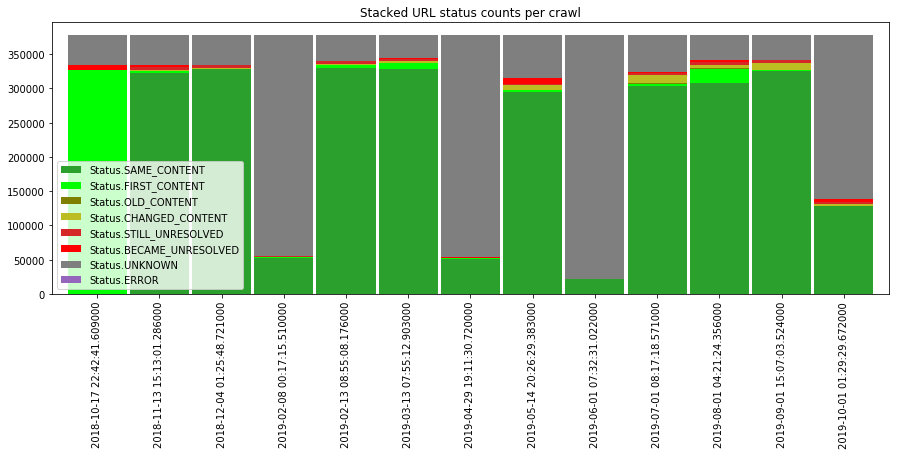

In [181]:
fig_df.plot(kind="bar", stacked=True, width=.95, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts per crawl");
plt.savefig(outputPath + "stacked-query-status-counts-per-crawl")

In [182]:
figureTitles = False

DataONE: Stacked URL Status Counts Over Time (Stepped)


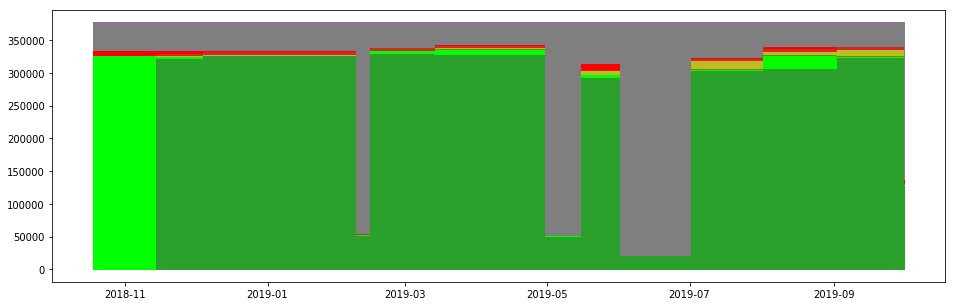

In [183]:
# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)
if figureTitles: plt.title(observatoryName + ": Stacked URL Status Counts Over Time (Stepped)")

# Fill in space between lines
x = fig_df.index.append(pd.Index([datetime.datetime.now()]))
y1 = pd.Series({ q : 0 for q in x })

columns = fig_df.columns
n = len(columns)
for i in range(0, n):
    y2 = y1 + fig_df[columns[i]] + 0
    ax.fill_between(x, y1, y2, step="post", color=status_color_map[i])
    y1 = y2

print(observatoryName + ": Stacked URL Status Counts Over Time (Stepped)")
plt.savefig(outputPath + "stacked-query-status-counts-over-time")

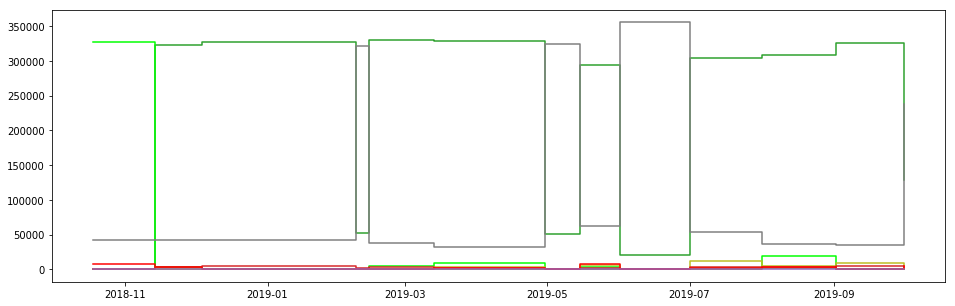

In [184]:
# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

# Draw stepped lines
x = fig_df.index
for status in fig_df.columns:
    y = fig_df[status]
    plt.step(x, y, where="post", color=col_hex[status_colors[status]])

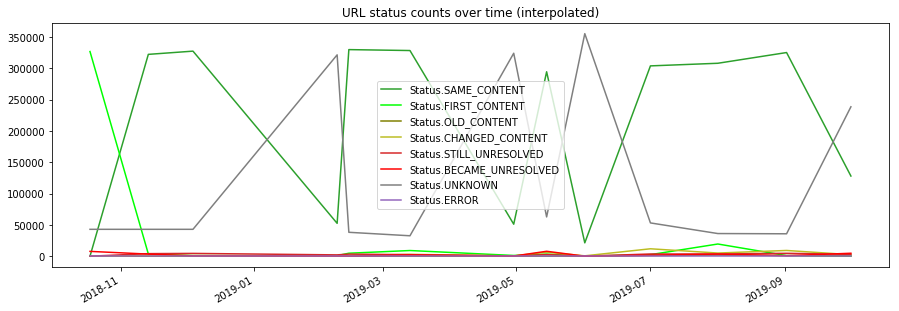

In [185]:
ax = fig_df.plot(kind="line", stacked=False, color=status_color_map, figsize=(15, 5),
                 title="URL status counts over time (interpolated)")

Fun fact: there are many URLs that never resolved

## Running URL and content totals

In [186]:
%%time

crawlUrlTotals = [0] * numCrawls
crawlDatasetTotals = [0] * numCrawls

numUnavailable = 0
numVeryAvailable = 0
numVeryStable = 0
numVeryReliable = 0

totalNumResolves = 0
totalNumBreaks = 0
totalNumContents = 0
totalNumContentChanges = 0
maxNumContentChanges = 0

maxNumBreaks   = totalNumUrls * (np.ceil(numCrawls / 2)) # Round up; if the availability is [0, 1, 0] across three crawls, there are at most two breaks
maxNumContents = totalNumUrls * (numCrawls)

breakCounts = []
contentChangeCounts = []

for _, lifetime in urlLifetimes.items():
    #if lifetime.firstCrawlPosition:
    crawlUrlTotals[lifetime.firstCrawlPosition] += 1

    totalNumResolves += lifetime.numResolves
    totalNumBreaks += lifetime.numBreaks
    totalNumContents += lifetime.numContents
    totalNumContentChanges += lifetime.numContentChanges
    maxNumContentChanges += lifetime.numResolves - 1

    breakCounts.append(lifetime.numBreaks)
    contentChangeCounts.append(lifetime.numContentChanges)

    if lifetime.numBreaks == 0:
        numVeryAvailable += 1

    if lifetime.numContents == 1:
        numVeryStable += 1

    if lifetime.numBreaks == 0 and lifetime.numContents == 1:
        numVeryReliable += 1

    if lifetime.lastKnownStatus in (Status.BECAME_UNRESOLVED, Status.STILL_UNRESOLVED):
        numUnavailable += 1

for _, lifetime in contentLifetimes.items():
    #if lifetime.firstCrawlPosition:
    crawlDatasetTotals[lifetime.firstCrawlPosition] += 1

reallyBads = list()
for url, lifetime in urlLifetimes.items():
    skip = False
    for status in lifetime.statuses:
        if status not in (Status.BECAME_UNRESOLVED, Status.STILL_UNRESOLVED, Status.UNKNOWN):
            skip = True
            break
    if not skip:
        reallyBads.append((url, lifetime))

numReallyBads = len(reallyBads)

np.save(outputPath + "totals", {
    "totalNumUrls" : totalNumUrls,
    "totalNumResolves" : totalNumResolves,
    "totalNumBreaks" : totalNumBreaks,
    "totalNumContents" : totalNumContents,
    "totalNumContentChanges" : totalNumContentChanges,
    "maxNumContentChanges" : maxNumContentChanges,
    "numReallyBads" : numReallyBads
})

CPU times: user 969 ms, sys: 15.6 ms, total: 984 ms
Wall time: 973 ms


In [187]:
textReport = ""

textReport += ("%s of URLs (%s total) were always available\n"
    % ("{0:.2%}".format(numVeryAvailable / totalNumUrls), "{0:,}".format(numVeryAvailable)))
textReport += ("%s of URLs (%s total) always produced the same content\n"
    % ("{0:.2%}".format(numVeryStable / totalNumUrls), "{0:,}".format(numVeryStable)))
textReport += ("%s of URLs (%s total) were always available and always produced the same content\n"
    % ("{0:.2%}".format(numVeryReliable / totalNumUrls), "{0:,}".format(numVeryReliable)))
textReport += ("%s of URLs (%s total) were unresolved in the last crawl\n"
    % ("{0:.2%}".format(numUnavailable / totalNumUrls), "{0:,}".format(numUnavailable)))
textReport += ("%s of URLs (%s total) never resolved in any crawl\n"
    % ("{0:.2%}".format(numReallyBads / totalNumUrls), "{0:,}".format(numReallyBads)))
textReport += ("On average, URLs break %s of the time between queries\n"
    % ("{0:.2%}".format(totalNumBreaks / (totalNumResolves + totalNumBreaks))))
textReport += ("On average, URLs contents change %s of the time between queries\n"
    % ("{0:.2%}".format(totalNumContentChanges / maxNumContentChanges)))

file = open(outputPath + "report.txt", "w+")
file.write(textReport)
file.close()

print(textReport)

92.93% of URLs (350,699 total) were always available
90.83% of URLs (342,795 total) always produced the same content
85.06% of URLs (321,024 total) were always available and always produced the same content
2.97% of URLs (11,191 total) were unresolved in the last crawl
1.05% of URLs (3,955 total) never resolved in any crawl
On average, URLs break 1.00% of the time between queries
On average, URLs contents change 1.66% of the time between queries



In [188]:
numUnreliable = totalNumUrls - numVeryReliable
numUnreliable

56371

In [189]:
numUnstable = totalNumUrls - numVeryStable
print(numUnstable)
print(numUnstable / numUnreliable)

34600
0.6137907789466215


In [190]:
numUnavailable = totalNumUrls - numVeryAvailable
print(numUnavailable)
print(numUnavailable / numUnreliable)

26696
0.4735768391548846


In [191]:
print(numUnavailable)
print(numUnavailable / numUnreliable)

26696
0.4735768391548846


In [192]:
breakCountFrequencies = np.unique(breakCounts, return_counts=True)
np.save(outputPath + "url-break-frequencies.npy", breakCountFrequencies)

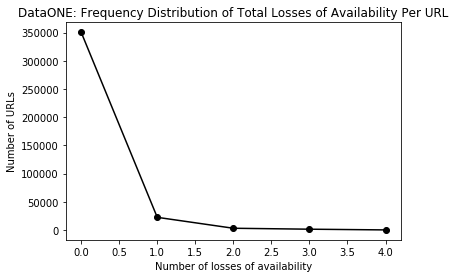

In [193]:
plt.plot(breakCountFrequencies[0], breakCountFrequencies[1], "-o", color="black");
plt.xlabel("Number of losses of availability");
plt.ylabel("Number of URLs");
plt.savefig(outputPath + "url-break-freq-dist.png")
plt.title(observatoryName + ": Frequency Distribution of Total Losses of Availability Per URL");

In [194]:
contentChangeCountFrequencies = np.unique(contentChangeCounts, return_counts=True)
np.save(outputPath + "url-content-change-frequencies.npy", contentChangeCountFrequencies)

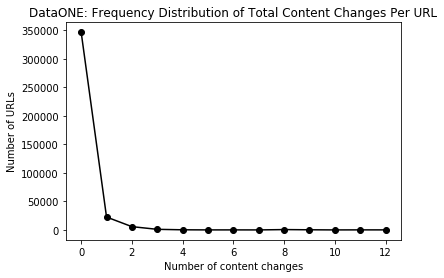

In [195]:
plt.plot(contentChangeCountFrequencies[0], contentChangeCountFrequencies[1], "-o", color="black");
plt.xlabel("Number of content changes");
plt.ylabel("Number of URLs");
plt.savefig(outputPath + "url-content-change-freq-dist.png")
plt.title(observatoryName + ": Frequency Distribution of Total Content Changes Per URL");

In [196]:
maxCount = max(len(breakCountFrequencies[0]), len(contentChangeCountFrequencies[0]))

frequencies_df = pd.DataFrame(
    columns=["Unresolvable", "Changed Content"],
    index=range(maxCount),
    data=0
)

for i, numBreaks in enumerate(breakCountFrequencies[0]):
    numUrls = breakCountFrequencies[1][i]
    frequencies_df["Unresolvable"][numBreaks] = numUrls

for i, numChanges in enumerate(contentChangeCountFrequencies[0]):
    numUrls = contentChangeCountFrequencies[1][i]
    frequencies_df["Changed Content"][numChanges] = numUrls

frequencies_df

,Unresolvable,Changed Content
0,350699,346750
1,22367,22602
2,2979,5743
3,1316,1038
4,34,211
5,0,28
6,0,45
7,0,2
8,0,589
9,0,239


Text(0.5,1,'DataONE: Frequency Distribution of Breaks and Changes')

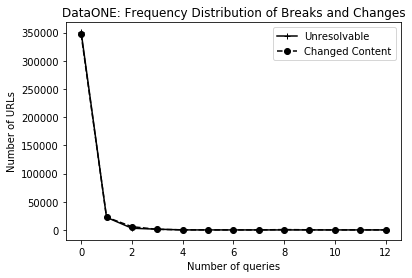

In [197]:
frequencies_df.plot(color="black", style=["-+", "--o"])
plt.ylabel("Number of URLs")
plt.xlabel("Number of queries")
plt.savefig(outputPath + "url-behavior-freq-dist")
plt.title(observatoryName + ": Frequency Distribution of Breaks and Changes")

In [199]:
crawl_totals_df = pd.DataFrame(
    index   = [datetime.datetime.strptime(str(x[1]), "%Y-%m-%dT%H:%M:%S.%fZ") for x in crawlDates],
    columns = ["New URLs", "New Contents", "Total URLs", "Total Contents"],
    data    = 0,
    dtype   = int
)

crawl_totals_df["New URLs"] = crawlUrlTotals
crawl_totals_df["New Contents"] = crawlDatasetTotals
crawl_totals_df["Total URLs"] = crawl_totals_df["New URLs"].cumsum()
crawl_totals_df["Total Contents"] = crawl_totals_df["New Contents"].cumsum()
crawl_totals_df

,New URLs,New Contents,Total URLs,Total Contents
2018-10-17 22:42:41.609,334469,203082,334469,203082
2018-11-13 15:13:01.286,0,2361,334469,205443
2018-12-04 01:25:48.721,0,1156,334469,206599
2019-02-08 00:17:15.510,1057,688,335526,207287
2019-02-13 08:55:08.176,4756,3949,340282,211236
2019-03-13 07:55:12.903,8102,6175,348384,217411
2019-04-29 19:11:30.720,1181,1069,349565,218480
2019-05-14 20:26:29.383,4518,8309,354083,226789
2019-06-01 07:32:31.022,0,606,354083,227395
2019-07-01 08:17:18.571,2494,13445,356577,240840


Text(0.5,1,'DataONE: Running Total of Unique URLs and Contents')

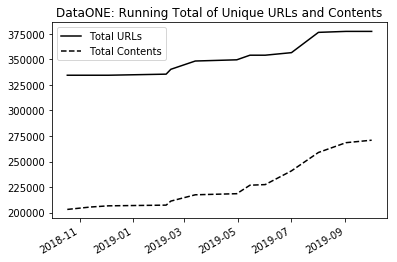

In [200]:
crawl_totals_df[["Total URLs", "Total Contents"]].plot(color="black", style=["-", "--"]);
plt.savefig(outputPath + "running-total-urls-and-contents.png")
plt.title(observatoryName + ": Running Total of Unique URLs and Contents")